## ***This notebook showcases how DMPNN-hERG(Cai et al datasets) , and Eos30f3 model generalise to new and unseen data. Done by Malik Badmus as part of Outreachy 2024 contributions***



***I will be running validation on two (2) seperate Models, DMPNN-hERG trained on cai et al datasets of 7889 molecules, and eos30f3 that was implemented on ersilia*** 

In [403]:
import os
import sys
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import inchi
import matplotlib.pyplot as plt

# search path for modules 
sys.path.append(os.path.abspath("../src"))
DATAPATH = "../data"
SRC= "../src"

#File path
output_path_file = os.path.join(DATAPATH, "Raw", "external.csv")
output_path_file_1 = os.path.join(DATAPATH, "Processed", "ex_DMPNN.csv")
output_path_file_2 = os.path.join(DATAPATH, "Processed", "ex_eos30f3.csv")
input_file_path = os.path.join(DATAPATH, "Raw", "Cai_TableS3_fixed.csv")
input_file_path_1 = os.path.join(DATAPATH, "Raw", "I_train.csv")


***The external datasets i am using for this validation was sourced from the theurapatic data commons, the TDC contains 11 (Eleven) toxicity related datasets, of these numbers, 3 (Three) of them are related to Human ether-à-go-go related gene (hERG), I choose the hERG blockers datasets, a part of the Tox prediction problem, which contains 648 drugs and their experimental results,To gauge both model performance to unseen data.***


In [404]:
# IMPORTING EXTERNAL DATASETS FROM TDC
from tdc.single_pred import Tox
data = Tox(name = 'hERG').get_data()
df = pd.DataFrame(data)
df.head()

Found local copy...
Loading...


Done!


,Drug_ID,Drug,Y
0,DEMETHYLASTEMIZOLE,Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1,1.0
1,GBR-12909,Fc1ccc(C(OCC[NH+]2CC[NH+](CCCc3ccccc3)CC2)c2cc...,1.0
2,LY-97241,CCCCCCCN(CC)CCCCc1ccc([N+](=O)[O-])cc1,1.0
3,CLOFILIUM PHOSPHATE,CCCCCCC[N+](CC)(CC)CCCCc1ccc(Cl)cc1.CCCCCCC[N+...,1.0
4,FLUSPIRILENE,O=C1NCN(c2ccccc2)C12CC[NH+](CCCC(c1ccc(F)cc1)c...,1.0


***Inspecting the external datasets***

In [405]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Drug_ID  633 non-null    object 
 1   Drug     655 non-null    object 
 2   Y        655 non-null    float64
dtypes: float64(1), object(2)
memory usage: 15.5+ KB


***We can observe that there are 655 drugs with their corresponding biaoactive label instead of 648 as stated on the website, this is most definitely a result of duplicated entries, let's go ahead and resolve this***


In [406]:
df.drop_duplicates(subset=['Drug'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 648 entries, 0 to 654
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Drug_ID  626 non-null    object 
 1   Drug     648 non-null    object 
 2   Y        648 non-null    float64
dtypes: float64(1), object(2)
memory usage: 20.2+ KB



### Removing molecules that were present both in cai et al datasets and datasets used to train the eos30f3 model, from our External Test set.



***It is important to note that different valid SMILES strings can represent the same molecular structure, Comparing this molecules based solely on SMILES strings might then lead to discrepancies, so it is crucial to generate the inchi keys of the Smiles column and based our comparison on that.***

In [407]:
from processing import generate_inchi_key

cai_dataset = pd.read_csv(input_file_path, delimiter=',')
eos30f3_datasets = pd.read_csv(input_file_path_1, delimiter=',')

df['Drug_ID'] = df['Drug'].apply(generate_inchi_key)
cai_dataset['inchi key'] = cai_dataset['smiles'].apply(generate_inchi_key)
eos30f3_datasets['inchi key'] = eos30f3_datasets['smiles'].apply(generate_inchi_key)

df.rename(columns={'Drug_ID': 'inchi key', 'Drug': 'smiles'}, inplace=True)
df.info()

[02:23:08] WARNING: not removing hydrogen atom without neighbors
[02:23:08] WARNING: not removing hydrogen atom without neighbors


<class 'pandas.core.frame.DataFrame'>
Index: 648 entries, 0 to 654
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inchi key  648 non-null    object 
 1   smiles     648 non-null    object 
 2   Y          648 non-null    float64
dtypes: float64(1), object(2)
memory usage: 20.2+ KB


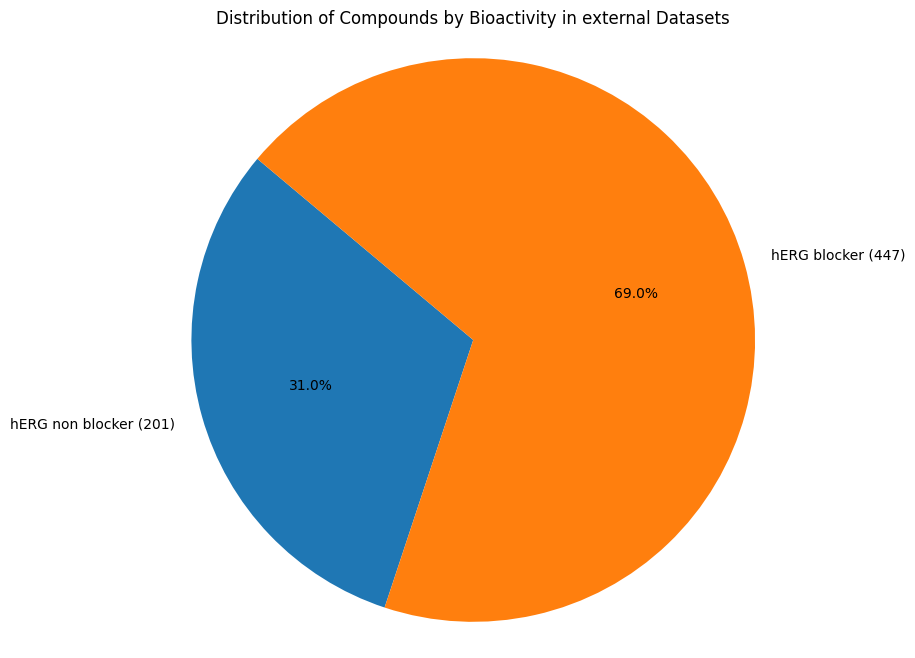

In [408]:
class_counts = df['Y'].value_counts()
class_names = {0: 'hERG non blocker', 1: 'hERG blocker'}


class_counts_sorted = class_counts.sort_index()
labels = class_counts_sorted.index.map(class_names)


plt.figure(figsize=(8, 8))  
wedges, texts, autotexts = plt.pie(class_counts_sorted, labels=labels, autopct='%1.1f%%', startangle=140)
for i, label in enumerate(texts):
    label.set_text(f"{label.get_text()} ({class_counts_sorted[i]})")

plt.title('Distribution of Compounds by Bioactivity in external Datasets')  
plt.axis('equal')  
plt.savefig('../figures/external_datasets_piechart.png')
plt.show()


***We can observe the classification of our molecules according to their inhibiting ability, the greater percentage of molecules in our external datasets inhibits the hERG channel***

In [409]:
df.drop_duplicates(subset=['inchi key'], inplace=True)

In [410]:
# Inspect cai datasets
cai_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7889 entries, 0 to 7888
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   smiles     7889 non-null   object 
 1   X10        7889 non-null   int64  
 2   X20        6548 non-null   float64
 3   X40        5434 non-null   float64
 4   X60        5161 non-null   float64
 5   X80        4940 non-null   float64
 6   X100       4831 non-null   float64
 7   inchi key  7889 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 493.2+ KB


In [411]:
# Inspect eos30f3 train sets
eos30f3_datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   smiles     392 non-null    object
 1   class      392 non-null    int64 
 2   inchi key  392 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.3+ KB


***

In [412]:
cai_common_values = df['inchi key'].isin(cai_dataset['inchi key'])
eos_common_values = df['inchi key'].isin(eos30f3_datasets['inchi key'])

cai_count = cai_common_values.sum()
eos_count = eos_common_values.sum()


print("The number of molecules from external datasets present in cai et al datasets is:", cai_count)
print("The number of molecules from external datasets present in eos30f3 training data is:", eos_count)


The number of molecules from external datasets present in cai et al datasets is: 504
The number of molecules from external datasets present in eos30f3 training data is: 392


***504 Molecules used in Training DMPNN-hERG model is present in our external test set, Likewise 392 Molecules used in training eos30f3, for the eos30f3 this is highly unusual, all the Molecules in the training set are present in our external test set, this will imply that the training set used by the author (I have been looking for the where the author got this training set from, as there was no mention of it in his publication) of the eos30f3 was gotten from TDC. I wll do a futher verification of this.***

***In the meantime, I will go ahead to remove this set of  molecules so that we will be left with new data that the model was not exposed to during training.***

In [413]:
new_df = df.copy()

new_df.drop(df.index[df['inchi key'].isin(eos30f3_datasets['inchi key'])], inplace=True)
new_df.reset_index(drop=True, inplace=True)
new_df.to_csv(output_path_file_2, index=False)

df.drop(df.index[df['inchi key'].isin(cai_dataset['inchi key'])], inplace=True)
df.drop(columns=['inchi key'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.to_csv(output_path_file_1, index=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   smiles  140 non-null    object 
 1   Y       140 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.3+ KB


In [414]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inchi key  252 non-null    object 
 1   smiles     252 non-null    object 
 2   Y          252 non-null    float64
dtypes: float64(1), object(2)
memory usage: 6.0+ KB


***We can observe the number of data points in each bioactivity class of our new datasets, I will go ahead and run predictions on both Models, making use of this datasets***

### Calculating the AUC-ROC value for both models to see how they generalize to new data

In [415]:
ex_DMPNN_preds = pd.read_csv(os.path.join(DATAPATH, "Model_predictions", "ex_DMPNN_preds.csv"))

AUC = 0.910 ± 0.024


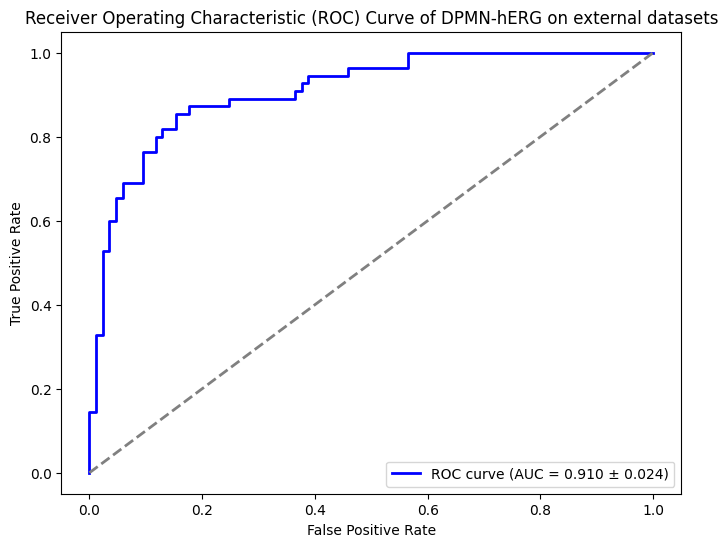

In [416]:
from sklearn.metrics import roc_curve, roc_auc_score


# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(df['Y'], ex_DMPNN_preds['X10'])
auc = roc_auc_score(df['Y'], ex_DMPNN_preds['X10'])

n_bootstraps = 1000
auc_values = np.zeros(n_bootstraps)
for i in range(n_bootstraps):
    indices = np.random.choice(len(df['Y']), len(df['Y']), replace=True)
    auc_values[i] = roc_auc_score(df['Y'].iloc[indices], ex_DMPNN_preds['X10'].iloc[indices])


auc_std_error = np.std(auc_values)

print(f"AUC = {auc:.3f} ± {auc_std_error:.3f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.3f} ± {auc_std_error:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve of DPMN-hERG on external datasets')
plt.legend(loc='lower right')
plt.savefig('../figures/ex_DMPNN_AUC.png')
plt.show()


In [417]:
eos30f3_preds = pd.read_csv(os.path.join(DATAPATH, "Model_predictions", "ex_eos30f3_output.csv"))

AUC = 0.809 ± 0.032


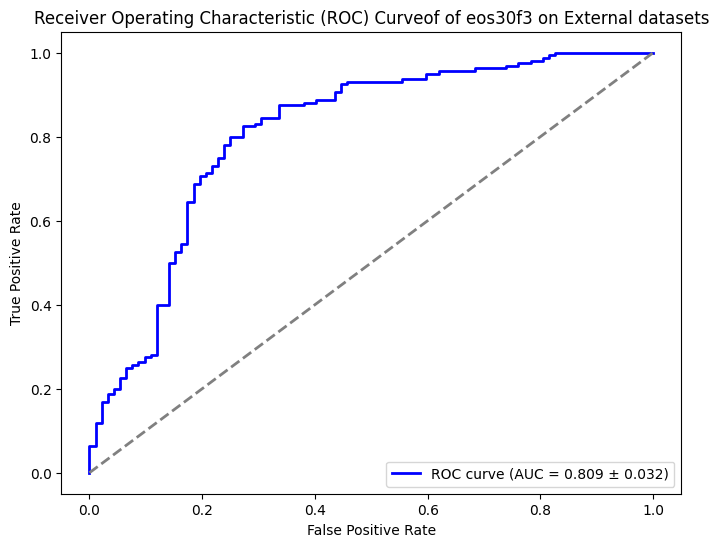

In [418]:
fpr, tpr, thresholds = roc_curve(new_df['Y'], eos30f3_preds['activity'])
auc = roc_auc_score(new_df['Y'], eos30f3_preds['activity'])

n_bootstraps = 1000
auc_values = np.zeros(n_bootstraps)
for i in range(n_bootstraps):
    indices = np.random.choice(len(new_df['Y']), len(new_df['Y']), replace=True)
    auc_values[i] = roc_auc_score(new_df['Y'].iloc[indices], eos30f3_preds['activity'].iloc[indices])


auc_std_error = np.std(auc_values)

print(f"AUC = {auc:.3f} ± {auc_std_error:.3f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.3f} ± {auc_std_error:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curveof of eos30f3 on External datasets')
plt.legend(loc='lower right')
plt.savefig('../figures/ex_eos30f3_AUC.png')
plt.show()


***From the above we can deduce that the Cai et al trained model is better at distinguishing between Molecules that inhibit the hERG ion pottasium channel, it also has less variability and a higher precision***

## Futher investigation into the Data source used to train eos30f3 Model
